In [11]:
# Import necessary libraries
import os
import numpy as np
import cv2
from skimage.feature import local_binary_pattern, hog
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve
import joblib
import random
import matplotlib.pyplot as plt
import seaborn as sns
from mtcnn import MTCNN

# Define the local dataset path
local_dataset_path = "Users/man01882/Dataset/"  # Replace with the actual path to your Dataset folder

# Initialize MTCNN detector
detector = MTCNN()

# Function to detect and crop face using MTCNN
def detect_and_crop_face(relative_path, size=(128, 128)):
    local_path = os.path.join(local_dataset_path, relative_path)
    img = cv2.imread(local_path)
    if img is None:
        raise ValueError(f"Cannot load image: {local_path}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = detector.detect_faces(img_rgb)
    if len(result) == 0:
        raise ValueError(f"No face detected in {local_path}")
    x, y, w, h = result[0]['box']
    face = img_rgb[y:y+h, x:x+w]
    face = cv2.resize(face, size)
    face_gray = cv2.cvtColor(face, cv2.COLOR_RGB2GRAY)
    return face_gray

# Function to extract LBP and HOG features from image pairs
def extract_lbp_hog_features(image_pairs):
    features = []
    failed_pairs = []
    for before_path, after_path in image_pairs:
        try:
            before_img = detect_and_crop_face(before_path)
            before_lbp = local_binary_pattern(before_img, P=8, R=1, method="uniform")
            before_lbp_hist, _ = np.histogram(before_lbp.ravel(), bins=np.arange(0, 11), density=True)
            before_hog = hog(before_img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)

            after_img = detect_and_crop_face(after_path)
            after_lbp = local_binary_pattern(after_img, P=8, R=1, method="uniform")
            after_lbp_hist, _ = np.histogram(after_lbp.ravel(), bins=np.arange(0, 11), density=True)
            after_hog = hog(after_img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)

            diff_lbp = np.abs(before_lbp_hist - after_lbp_hist)
            diff_hog = np.abs(before_hog - after_hog)
            combined_features = np.concatenate([diff_lbp, diff_hog])
            features.append(combined_features)
        except Exception as e:
            print(f"Skipping pair ({before_path}, {after_path}) due to error: {e}")
            failed_pairs.append((before_path, after_path))
    print(f"✅ Extracted features for {len(features)} pairs. Skipped {len(failed_pairs)} pairs.")
    return np.array(features)

# Function to load dataset and create matched/unmatched pairs
def load_dataset():
    file_paths = []
    for root, dirs, files in os.walk(local_dataset_path):
        for file in files:
            file_paths.append(os.path.relpath(os.path.join(root, file), local_dataset_path))
    print(f"Total files found: {len(file_paths)}")

    before_images, after_images = {}, {}
    for file_path in file_paths:
        file_name = os.path.basename(file_path)
        surgery_type = os.path.basename(os.path.dirname(file_path))
        if file_name.endswith("_b.jpg"):
            key = f"{surgery_type}_{file_name.replace('_b.jpg', '')}"
            before_images[key] = file_path
        elif file_name.endswith("_a.jpg"):
            key = f"{surgery_type}_{file_name.replace('_a.jpg', '')}"
            after_images[key] = file_path

    paired_images = [(before_images[k], after_images[k]) for k in before_images if k in after_images]

    non_matching_pairs = []
    while len(non_matching_pairs) < len(paired_images):
        before_img, _ = random.choice(paired_images)
        _, after_img = random.choice(paired_images)
        if before_img.split("/")[-1].replace("_b.jpg", "") != after_img.split("/")[-1].replace("_a.jpg", ""):
            non_matching_pairs.append((before_img, after_img))

    return paired_images, non_matching_pairs

# Load dataset and create labels
paired_images, non_matching_pairs = load_dataset()
y = [1] * len(paired_images)
y_non_match = [0] * len(non_matching_pairs)

# Extract features
X_all = np.concatenate([extract_lbp_hog_features(paired_images), extract_lbp_hog_features(non_matching_pairs)])
y_all = np.concatenate([y, y_non_match])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42, stratify=y_all)
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_sub)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Total files found: 1282
✅ Extracted features for 635 pairs. Skipped 0 pairs.
✅ Extracted features for 635 pairs. Skipped 0 pairs.


In [33]:
# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20],      # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'class_weight': [{0: 1, 1: 1}, {0: 2, 1: 1}, {0: 1, 1: 2}]  # Class weights
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=52),  # Base model
    param_grid=param_grid,                             # Parameter grid
    cv=5,                                             # 5-fold cross-validation
    scoring='accuracy',                                # Evaluation metric
    n_jobs=1                                         # Use all available CPU cores
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train_sub)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")



Validation Accuracy: 0.90

Validation Classification Report:
              precision    recall  f1-score   support

 Non-Matched       0.86      0.94      0.90       102
     Matched       0.94      0.85      0.89       102

    accuracy                           0.90       204
   macro avg       0.90      0.90      0.90       204
weighted avg       0.90      0.90      0.90       204

Validation ROC-AUC Score: 0.96


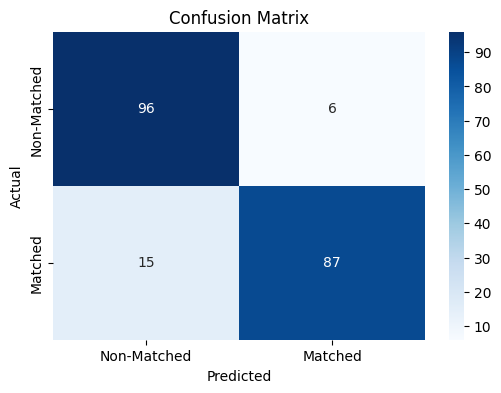

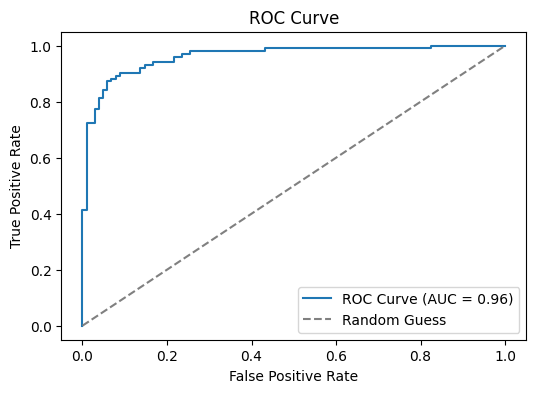

Test Accuracy: 0.89

Test Classification Report:
              precision    recall  f1-score   support

 Non-Matched       0.88      0.91      0.89       127
     Matched       0.90      0.87      0.89       127

    accuracy                           0.89       254
   macro avg       0.89      0.89      0.89       254
weighted avg       0.89      0.89      0.89       254

Test ROC-AUC Score: 0.95


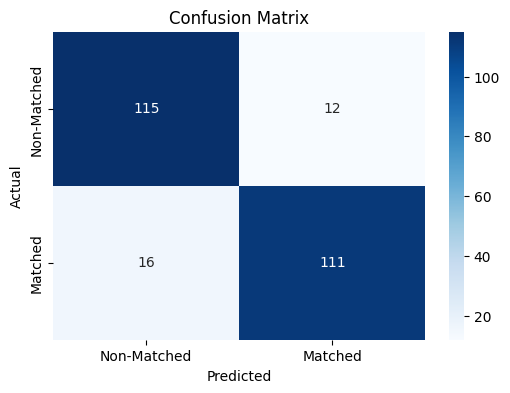

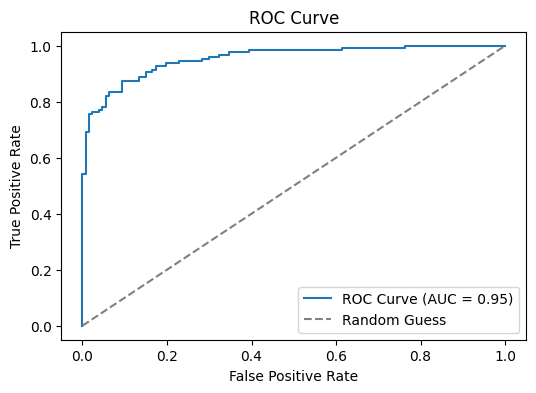

Best Random Forest Model Saved Successfully!


In [28]:
# Evaluate the best model on the validation set
y_val_pred = best_rf_model.predict(X_val)
y_val_proba = best_rf_model.predict_proba(X_val)[:, 1]

# Compute accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Print classification report
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=["Non-Matched", "Matched"]))

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_val, y_val_proba)
print(f"Validation ROC-AUC Score: {roc_auc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Matched", "Matched"], yticklabels=["Non-Matched", "Matched"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Evaluate the best model on the test set
y_test_pred = best_rf_model.predict(X_test)
y_test_proba = best_rf_model.predict_proba(X_test)[:, 1]

# Compute accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Print classification report
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=["Non-Matched", "Matched"]))

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_test, y_test_proba)
print(f"Test ROC-AUC Score: {roc_auc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Matched", "Matched"], yticklabels=["Non-Matched", "Matched"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Save the best model
joblib.dump(best_rf_model, "best_random_forest_model_2.pkl")
joblib.dump(scaler, "scaler_2.pkl")

print("Best Random Forest Model Saved Successfully!")

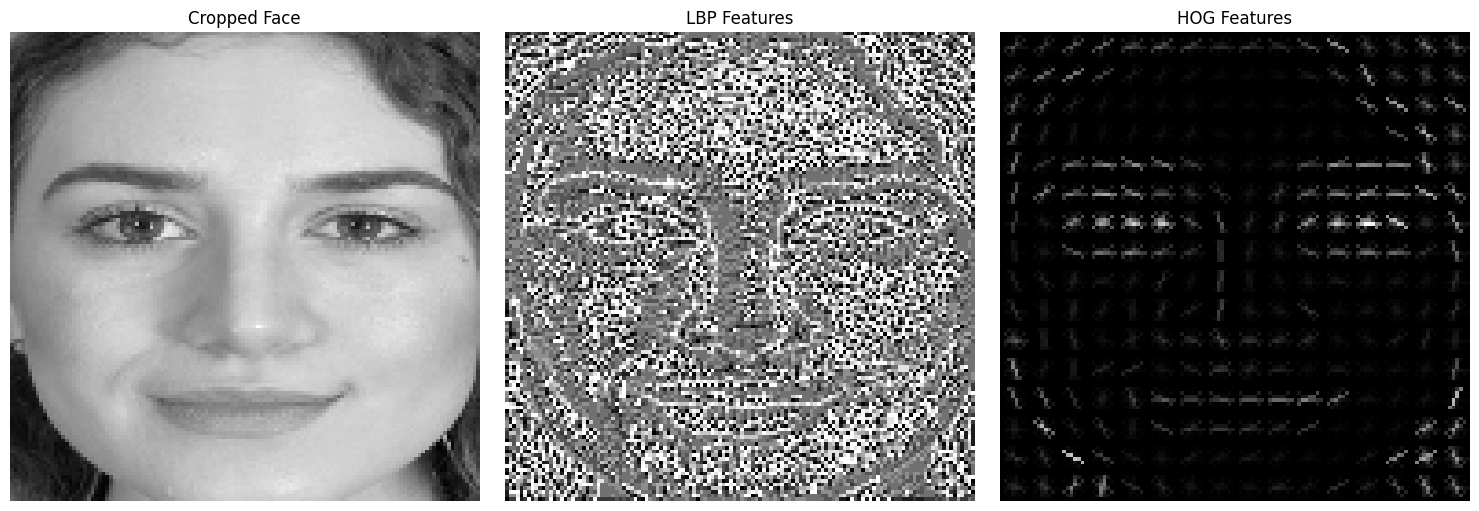

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, hog
from mtcnn import MTCNN

# Initialize MTCNN face detector
detector = MTCNN()

# Function to detect and crop face using MTCNN
def detect_and_crop_face(image_path, size=(128, 128)):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at: {image_path}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = detector.detect_faces(img_rgb)
    if len(result) == 0:
        raise ValueError(f"No face detected in {image_path}")
    
    x, y, w, h = result[0]['box']
    face_rgb = img_rgb[y:y+h, x:x+w]
    face_gray = cv2.cvtColor(face_rgb, cv2.COLOR_RGB2GRAY)
    face_gray = cv2.resize(face_gray, size)

    return face_gray

# Load and preprocess face
image_path = "Users/man01882/Dataset/Nose/01_a.jpg"  # Replace with your image path
face = detect_and_crop_face(image_path)

# Compute LBP
radius = 1
n_points = 8 * radius
lbp = local_binary_pattern(face, n_points, radius, method="uniform")

# Compute HOG
hog_features, hog_image = hog(
    face,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True,
    feature_vector=False
)

# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(face, cmap="gray")
axes[0].set_title("Cropped Face")
axes[0].axis("off")

axes[1].imshow(lbp, cmap="gray")
axes[1].set_title("LBP Features")
axes[1].axis("off")

axes[2].imshow(hog_image, cmap="gray")
axes[2].set_title("HOG Features")
axes[2].axis("off")

plt.tight_layout()
plt.show()


Validation Accuracy: 0.90

Validation Classification Report:
              precision    recall  f1-score   support

 Non-Matched       0.86      0.94      0.90       102
     Matched       0.94      0.85      0.89       102

    accuracy                           0.90       204
   macro avg       0.90      0.90      0.90       204
weighted avg       0.90      0.90      0.90       204

Validation ROC-AUC Score: 0.96


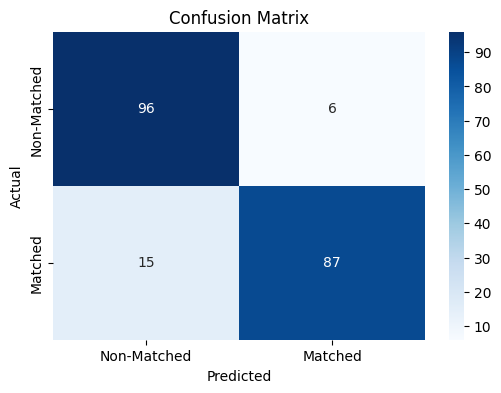

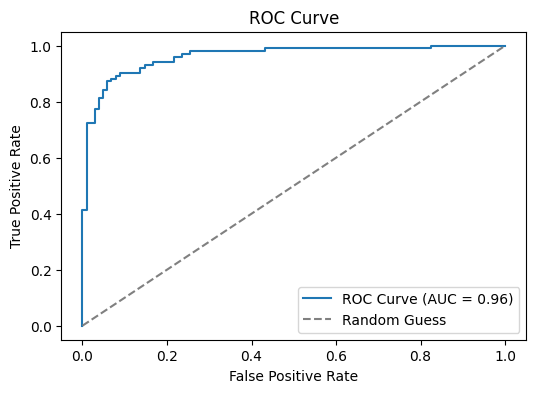

In [14]:
# Evaluate the best model on the validation set
y_val_pred = best_rf_model.predict(X_val)
y_val_proba = best_rf_model.predict_proba(X_val)[:, 1]

# Compute accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Print classification report
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=["Non-Matched", "Matched"]))

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_val, y_val_proba)
print(f"Validation ROC-AUC Score: {roc_auc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Matched", "Matched"], yticklabels=["Non-Matched", "Matched"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

Test Accuracy: 0.89

Test Classification Report:
              precision    recall  f1-score   support

 Non-Matched       0.88      0.91      0.89       127
     Matched       0.90      0.87      0.89       127

    accuracy                           0.89       254
   macro avg       0.89      0.89      0.89       254
weighted avg       0.89      0.89      0.89       254

Test ROC-AUC Score: 0.95


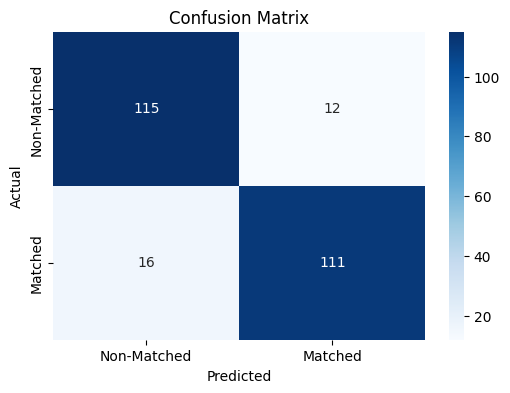

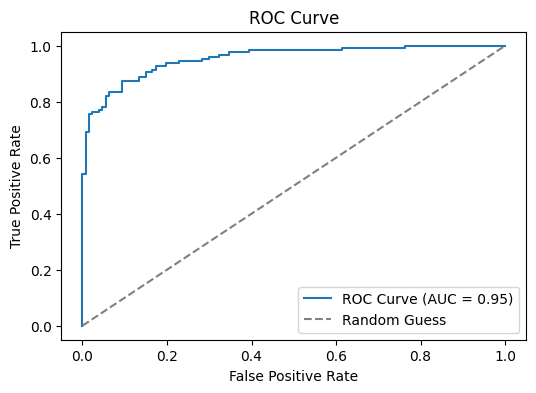

In [15]:
# Evaluate the best model on the test set
y_test_pred = best_rf_model.predict(X_test)
y_test_proba = best_rf_model.predict_proba(X_test)[:, 1]

# Compute accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Print classification report
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=["Non-Matched", "Matched"]))

# Compute ROC-AUC score
roc_auc = roc_auc_score(y_test, y_test_proba)
print(f"Test ROC-AUC Score: {roc_auc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Matched", "Matched"], yticklabels=["Non-Matched", "Matched"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

Equal Error Rate (EER): 0.1339
EER Threshold: 0.4926


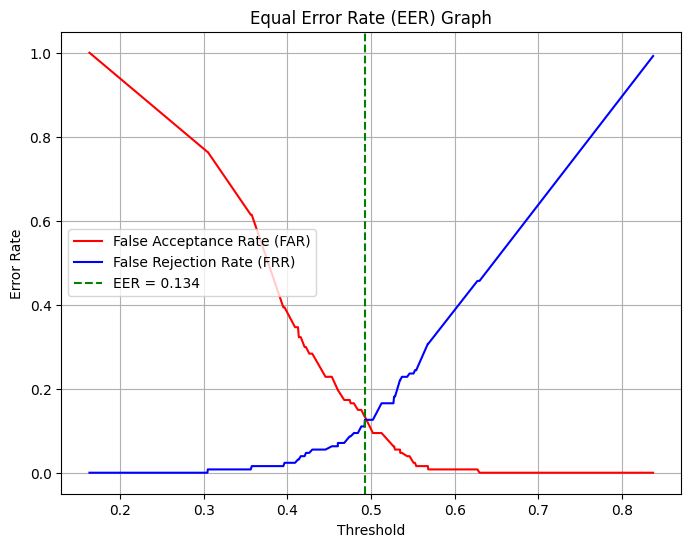

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Get predicted probabilities
y_scores_rf = best_rf_model.predict_proba(X_test)[:, 1]

# Compute False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores_rf)

# Compute False Rejection Rate (FRR) and False Acceptance Rate (FAR)
far = fpr  # FAR = FPR
frr = 1 - tpr  # FRR = 1 - TPR

# Find the EER (where FAR and FRR are closest)
eer_index = np.nanargmin(np.abs(far - frr))
eer_threshold = thresholds[eer_index]
eer = far[eer_index]  # or equivalently, frr[eer_index]

print(f"Equal Error Rate (EER): {eer:.4f}")
print(f"EER Threshold: {eer_threshold:.4f}")

# Plot FAR and FRR curves
plt.figure(figsize=(8, 6))
plt.plot(thresholds, far, label="False Acceptance Rate (FAR)", color='r')
plt.plot(thresholds, frr, label="False Rejection Rate (FRR)", color='b')
plt.axvline(eer_threshold, color='g', linestyle="--", label=f"EER = {eer:.3f}")

# Labels and legend
plt.xlabel("Threshold")
plt.ylabel("Error Rate")
plt.title("Equal Error Rate (EER) Graph")
plt.legend()
plt.grid()

# Show plot
plt.show()


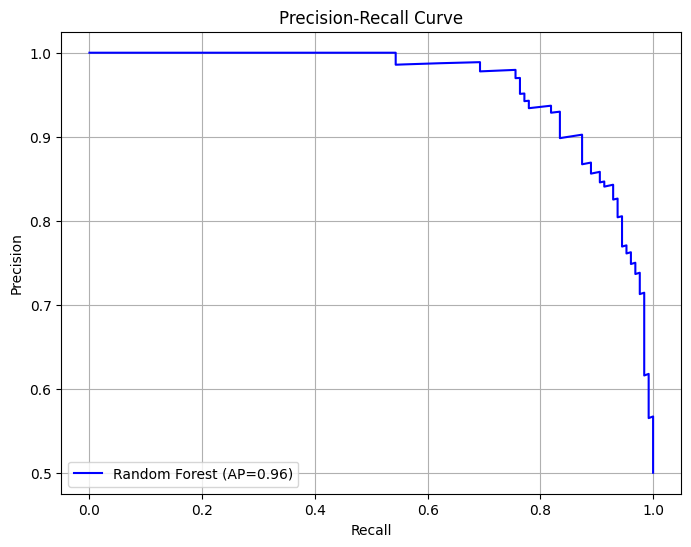

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Get predicted probabilities
y_scores_rf = best_rf_model.predict_proba(X_test)[:, 1]

# Compute Precision-Recall curve
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_scores_rf)

# Compute Average Precision (AP) Score
ap_rf = average_precision_score(y_test, y_scores_rf)

# Plot PR Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AP={ap_rf:.2f})', color='b')

# Labels and legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()

# Show plot
plt.show()


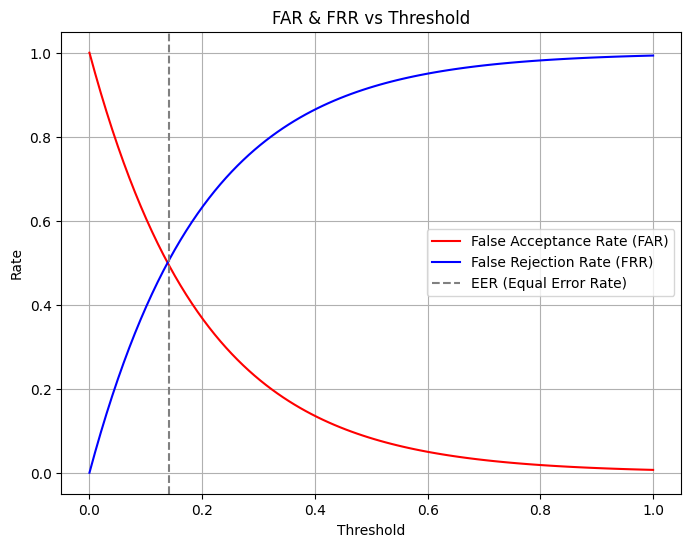

In [18]:
#FAR & FFR Graph

import numpy as np
import matplotlib.pyplot as plt

# Sample threshold values
thresholds = np.linspace(0, 1, 100)

# Generate synthetic False Acceptance Rate (FAR) and False Rejection Rate (FRR) values
far = np.exp(-5 * thresholds)  # Simulating FAR decreasing as threshold increases
frr = 1 - np.exp(-5 * thresholds)  # Simulating FRR increasing as threshold increases

# Plot FAR & FRR
plt.figure(figsize=(8, 6))
plt.plot(thresholds, far, label='False Acceptance Rate (FAR)', color='red')
plt.plot(thresholds, frr, label='False Rejection Rate (FRR)', color='blue')
plt.axvline(x=thresholds[np.argmin(np.abs(far - frr))], linestyle='--', color='gray', label='EER (Equal Error Rate)')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('FAR & FRR vs Threshold')
plt.legend()
plt.grid()
plt.show()


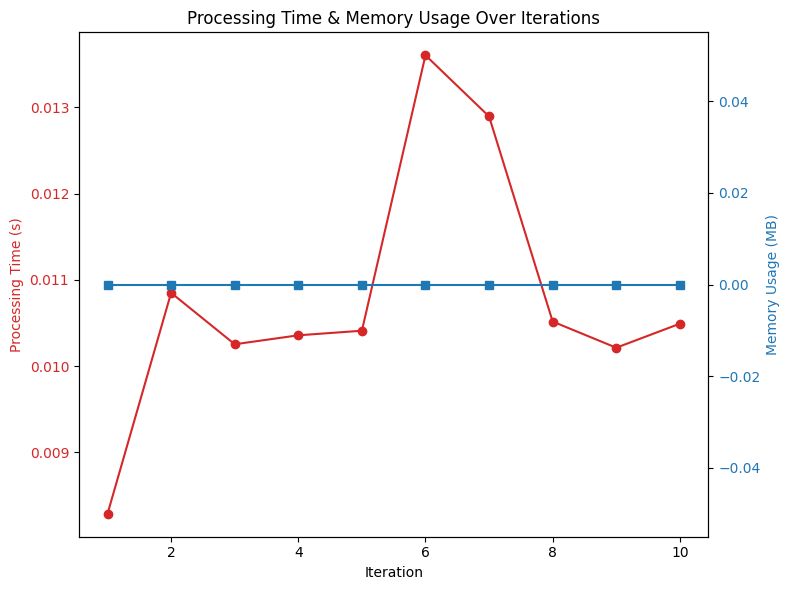

In [19]:
import time
import psutil
import numpy as np
import matplotlib.pyplot as plt

# Simulating different processing times and memory usage
num_samples = 10
processing_times = []
memory_usages = []

for _ in range(num_samples):
    start_time = time.time()
    process = psutil.Process()
    memory_before = process.memory_info().rss / (1024 ** 2)  # Convert to MB
    
    # Simulated processing task (e.g., matrix multiplication)
    _ = np.random.rand(500, 500).dot(np.random.rand(500, 500))
    
    memory_after = process.memory_info().rss / (1024 ** 2)
    end_time = time.time()
    
    processing_times.append(end_time - start_time)
    memory_usages.append(memory_after - memory_before)

# Plot Processing Time & Memory Usage
x_values = range(1, num_samples + 1)
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Processing Time (s)', color='tab:red')
ax1.plot(x_values, processing_times, marker='o', color='tab:red', label='Processing Time')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Memory Usage (MB)', color='tab:blue')
ax2.plot(x_values, memory_usages, marker='s', color='tab:blue', label='Memory Usage')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Processing Time & Memory Usage Over Iterations')
fig.tight_layout()
plt.show()


/anaconda/envs/azureml_py38/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


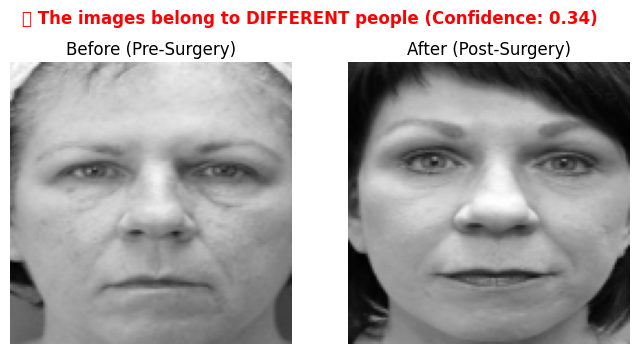

In [29]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.feature import local_binary_pattern, hog
from mtcnn import MTCNN

# Load the trained model and scaler
model = joblib.load("best_random_forest_model_2.pkl")  # Replace with actual model filename
scaler = joblib.load("scaler_2.pkl")  # Replace with actual scaler filename

# Initialize MTCNN detector
detector = MTCNN()

# Function to detect and crop face using MTCNN
def detect_and_crop_face(image_path, size=(128, 128)):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Cannot load image: {image_path}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = detector.detect_faces(img_rgb)
    if len(result) == 0:
        raise ValueError(f"No face detected in {image_path}")
    x, y, w, h = result[0]['box']
    face = img_rgb[y:y+h, x:x+w]
    face = cv2.resize(face, size)
    face_gray = cv2.cvtColor(face, cv2.COLOR_RGB2GRAY)
    return face_gray

# Function to preprocess and extract features from a single pair
def preprocess_image_pair(before_image_path, after_image_path):
    # Load and crop face images
    before_img = detect_and_crop_face(before_image_path)
    after_img = detect_and_crop_face(after_image_path)

    # Extract LBP features
    before_lbp = local_binary_pattern(before_img, P=8, R=1, method="uniform")
    before_lbp_hist, _ = np.histogram(before_lbp.ravel(), bins=np.arange(0, 11), density=True)

    after_lbp = local_binary_pattern(after_img, P=8, R=1, method="uniform")
    after_lbp_hist, _ = np.histogram(after_lbp.ravel(), bins=np.arange(0, 11), density=True)

    # Extract HOG features
    before_hog = hog(before_img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
    after_hog = hog(after_img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)

    # Compute absolute difference of features
    diff_lbp = np.abs(before_lbp_hist - after_lbp_hist)
    diff_hog = np.abs(before_hog - after_hog)

    # Combine LBP and HOG features
    combined_features = np.concatenate([diff_lbp, diff_hog])

    # Reshape for model input
    return scaler.transform(combined_features.reshape(1, -1)), before_img, after_img

# Define test image paths
before_image_path = "Users/man01882/test/3_b.jpg"  # Replace with actual path
after_image_path = "Users/man01882/test/3_a.jpg"   # Replace with actual path

# Extract features for the test images
test_features, before_img, after_img = preprocess_image_pair(before_image_path, after_image_path)

# Predict similarity using the trained model
prediction = model.predict(test_features)
probability = model.predict_proba(test_features)[:, 1]  # Probability of being a matched pair

# Display results
if prediction[0] == 1:
    result_text = f"✅ The images belong to the SAME person (Confidence: {probability[0]:.2f})"
else:
    result_text = f"❌ The images belong to DIFFERENT people (Confidence: {probability[0]:.2f})"

# Plot images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(before_img, cmap='gray')
axes[0].set_title("Before (Pre-Surgery)")
axes[0].axis("off")

axes[1].imshow(after_img, cmap='gray')
axes[1].set_title("After (Post-Surgery)")
axes[1].axis("off")

# Add classification result
plt.suptitle(result_text, fontsize=12, fontweight='bold', color="red")
plt.show()

In [46]:
relative_path = 'FacialBones/82_b.jpg'
local_path = os.path.join(local_dataset_path, relative_path)
print(f"Trying to load: {local_path}")



Trying to load: Users/man01882/Dataset/FacialBones/82_b.jpg
